In [20]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import random

# Define random order function
def random_order(graph):
    nodes = list(graph.nodes())
    random.shuffle(nodes)
    return nodes

# Define resilience computation function
def compute_resilience_adding_nodes(graph, attack_order):
    initial_nodes = graph.number_of_nodes()
    resilience = [0]  # Initialize with 0 to ensure the plot starts from 0
    added_graph = nx.Graph()
    
    for node in attack_order:
        added_graph.add_node(node)
        for neighbor in graph.neighbors(node):
            if added_graph.has_node(neighbor):
                added_graph.add_edge(node, neighbor)
        remaining_components = list(nx.connected_components(added_graph))
        if remaining_components:
            resilience.append(len(max(remaining_components, key=len)))
        else:
            resilience.append(0)
    return resilience

# Define community resilience computation function
def compute_community_resilience(graph, partition):
    community_resilience = {}
    for comm_id in set(partition.values()):
        subgraph_nodes = [node for node in partition if partition[node] == comm_id]
        subgraph = graph.subgraph(subgraph_nodes).copy()
        attack_order = random_order(subgraph)
        resilience = compute_resilience_adding_nodes(subgraph, attack_order)
        community_resilience[comm_id] = resilience
    return community_resilience


In [21]:
# Load the preprocessed Email graph
email_graph = nx.read_gml('data/email_graph.gml')

# Detect communities using the Louvain method
partition_email = community_louvain.best_partition(email_graph)
print(f"Number of communities detected: {len(set(partition_email.values()))}")

# Calculate modularity
modularity_email = community_louvain.modularity(partition_email, email_graph)
print(f"Email dataset modularity: {modularity_email}")

# Generate synthetic models
degree_sequence = [d for n, d in email_graph.degree()]
configuration_model_email = nx.configuration_model(degree_sequence)
ba_model_email = nx.barabasi_albert_graph(email_graph.number_of_nodes(), int(sum(degree_sequence) / email_graph.number_of_nodes()))

# Convert configuration model to a simple graph
configuration_model_email = nx.Graph(configuration_model_email)

# Detect communities in synthetic models
partition_configuration_model_email = community_louvain.best_partition(configuration_model_email)
partition_ba_email = community_louvain.best_partition(ba_model_email)


Number of communities detected: 8
Email dataset modularity: 0.4138536022586695


In [22]:
# Compute community resilience for original and synthetic models
community_resilience_email = compute_community_resilience(email_graph, partition_email)
community_resilience_configuration_email = compute_community_resilience(configuration_model_email, partition_configuration_model_email)
community_resilience_ba_email = compute_community_resilience(ba_model_email, partition_ba_email)


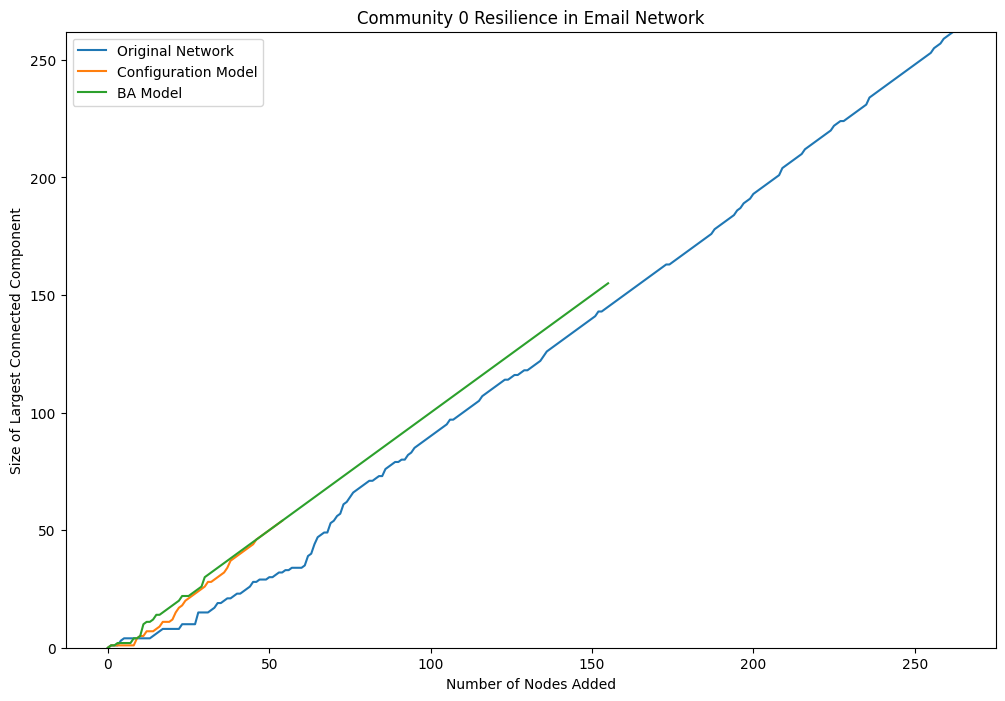

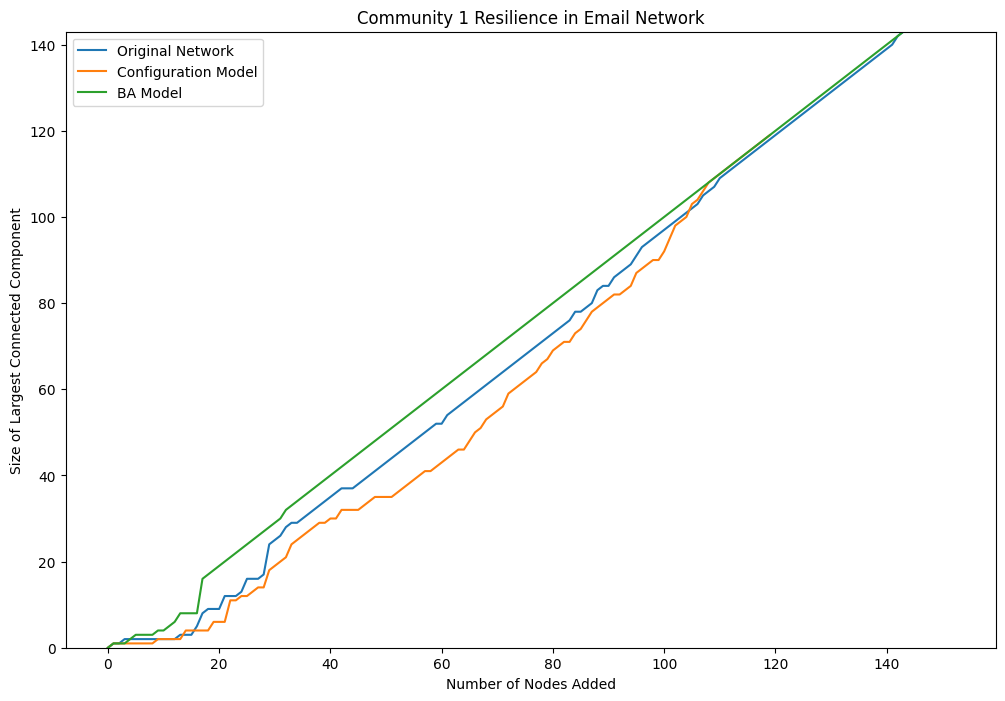

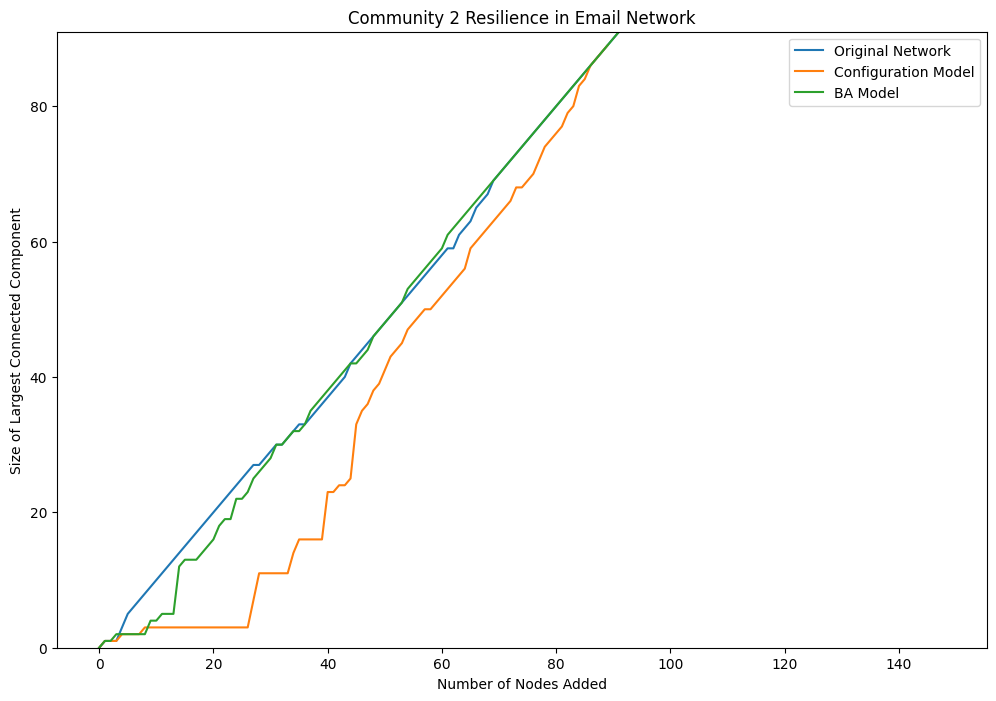

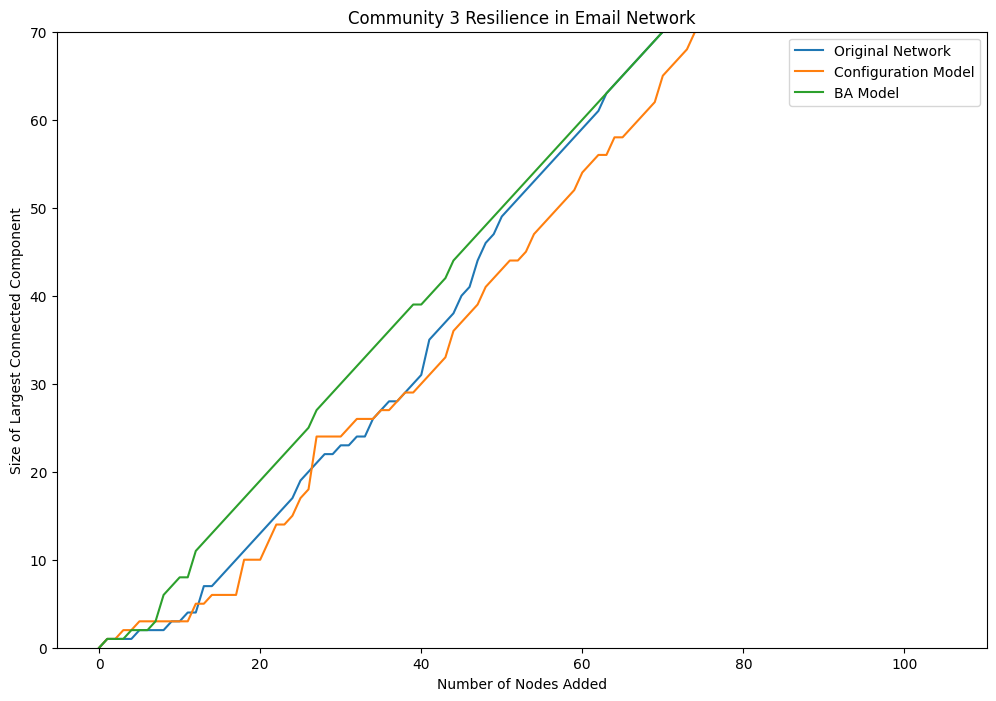

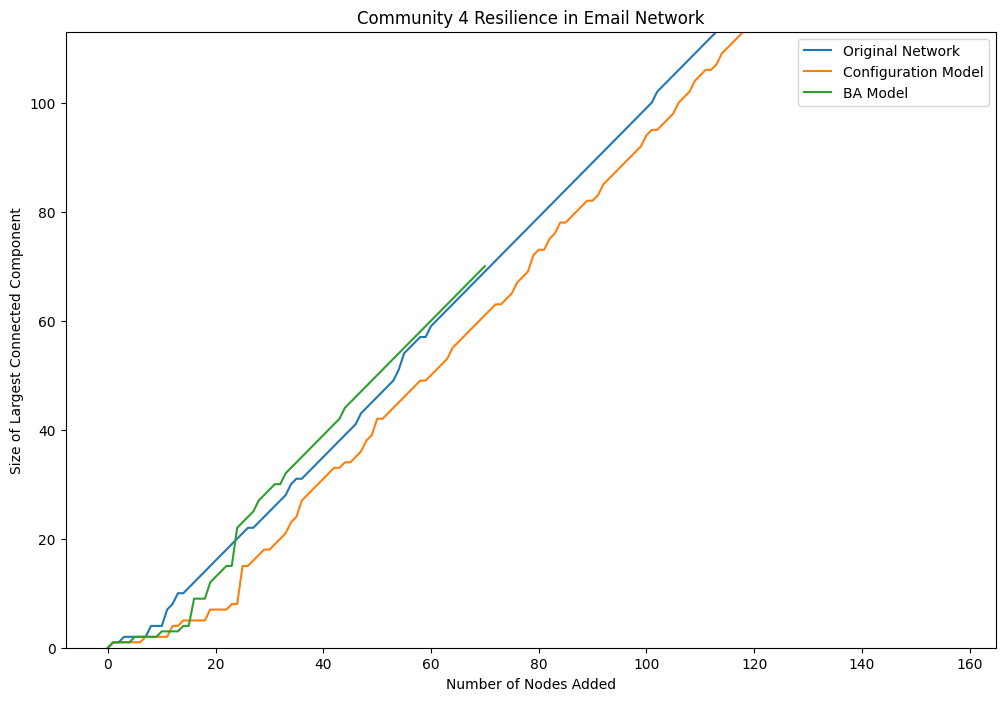

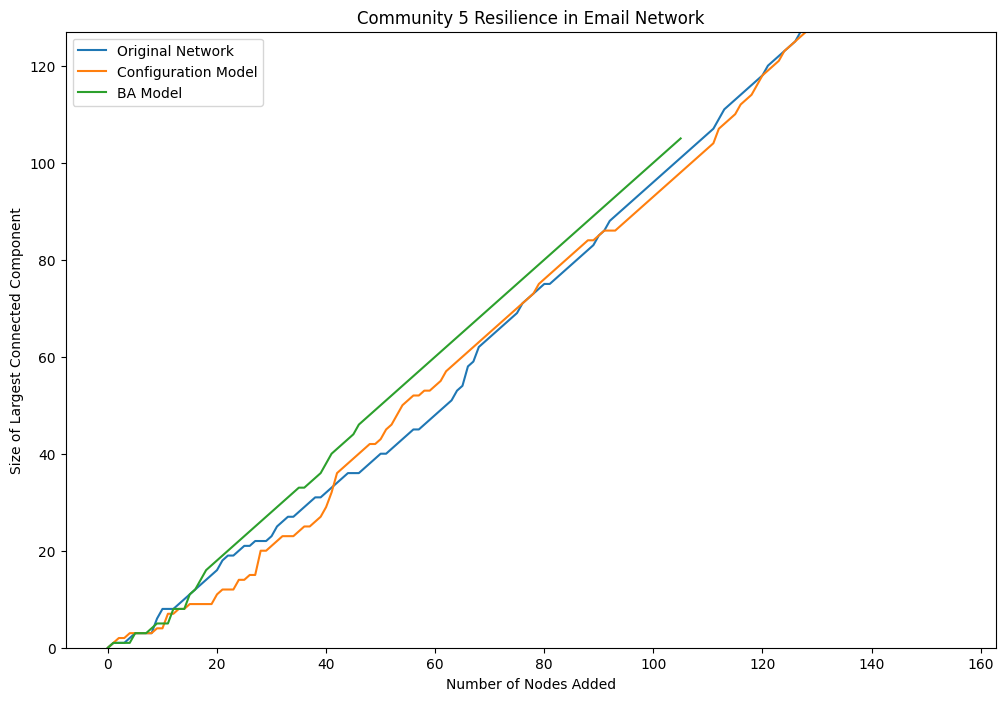

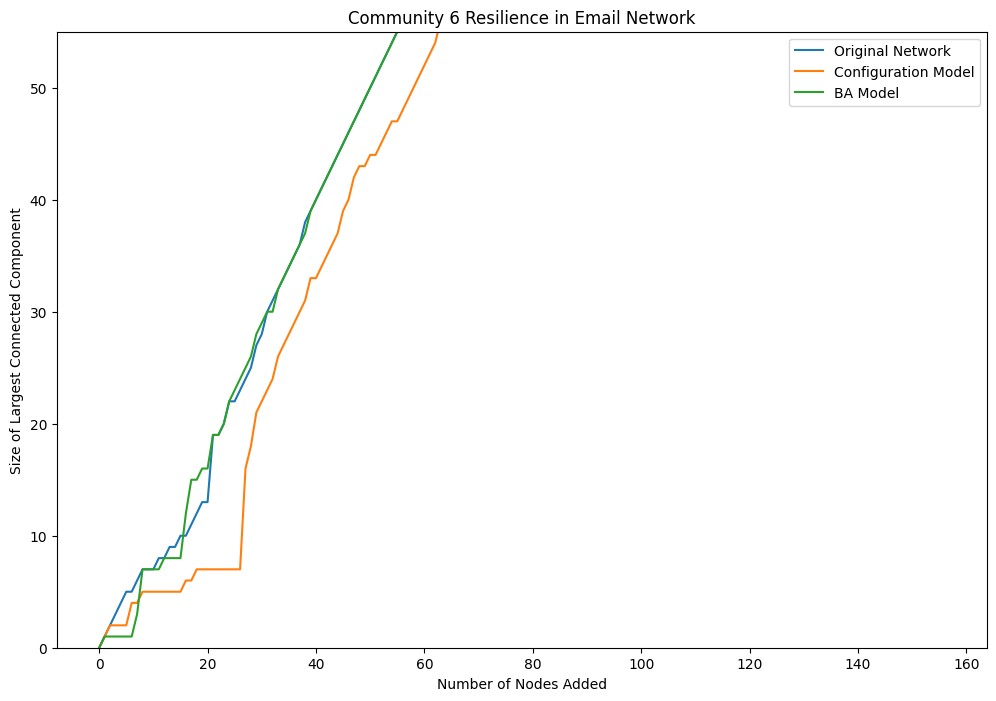

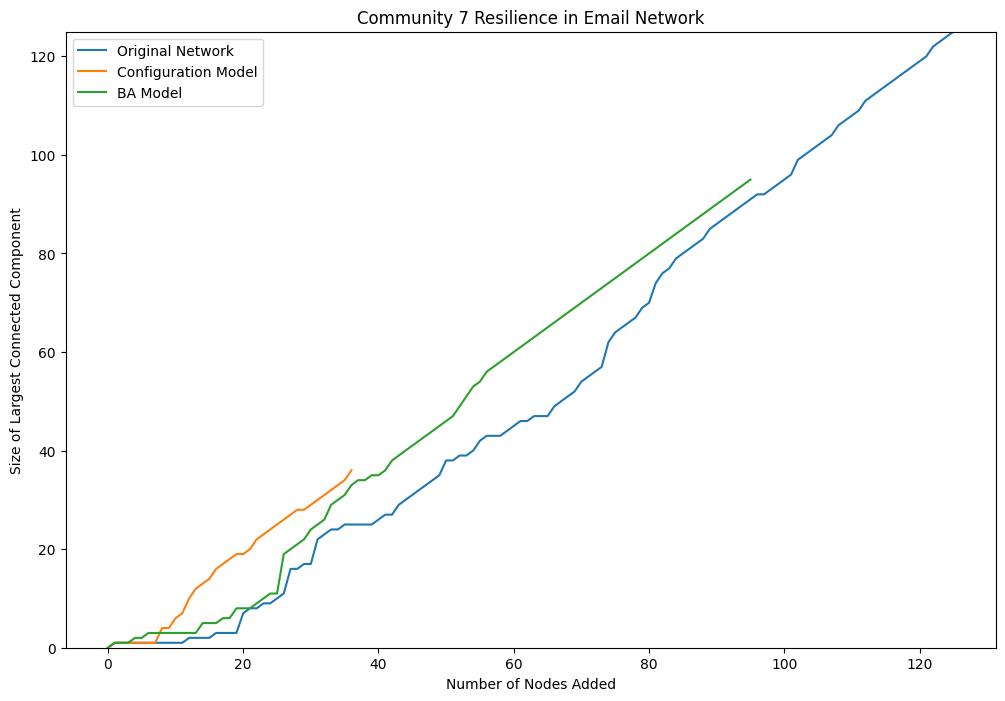

In [23]:
# Plot community resilience
for comm_id in community_resilience_email:
    plt.figure(figsize=(12, 8))
    plt.plot(community_resilience_email[comm_id], label='Original Network')
    if comm_id in community_resilience_configuration_email:
        plt.plot(community_resilience_configuration_email[comm_id], label='Configuration Model')
    if comm_id in community_resilience_ba_email:
        plt.plot(community_resilience_ba_email[comm_id], label='BA Model')
    plt.xlabel('Number of Nodes Added')
    plt.ylabel('Size of Largest Connected Component')
    plt.title(f'Community {comm_id} Resilience in Email Network')
    plt.ylim(0, max(community_resilience_email[comm_id]))  # Set y-axis to start from 0
    plt.legend()
    plt.show()


In [24]:
import pandas as pd

# Initialize an empty list to store the data for the table
table_data = []

# Loop through each community and gather resilience data
for comm_id in community_resilience_email:
    max_resilience_original = max(community_resilience_email[comm_id])
    max_resilience_configuration = max(community_resilience_configuration_email[comm_id]) if comm_id in community_resilience_configuration_email else "N/A"
    max_resilience_ba = max(community_resilience_ba_email[comm_id]) if comm_id in community_resilience_ba_email else "N/A"
    
    # Append the data for this community to the list
    table_data.append([comm_id, max_resilience_original, max_resilience_configuration, max_resilience_ba])

# Convert the list into a DataFrame for better visualization
resilience_table = pd.DataFrame(table_data, columns=["Community ID", "Original Network Resilience", "Configuration Model Resilience", "BA Model Resilience"])

# Display the table
print(resilience_table)


   Community ID  Original Network Resilience  Configuration Model Resilience  \
0             0                          262                              54   
1             1                          143                             119   
2             2                           91                              89   
3             3                           70                              89   
4             4                          113                             157   
5             5                          127                             155   
6             6                           55                             125   
7             7                          125                              36   

   BA Model Resilience  
0                  155  
1                  152  
2                  148  
3                  105  
4                   70  
5                  105  
6                  156  
7                   95  


Node 0 not found in labels_df
Node 1 not found in labels_df
Node 2 not found in labels_df
Node 3 not found in labels_df
Node 4 not found in labels_df
Node 5 not found in labels_df
Node 6 not found in labels_df
Node 7 not found in labels_df
Node 8 not found in labels_df
Node 9 not found in labels_df
Node 10 not found in labels_df
Node 11 not found in labels_df
Node 12 not found in labels_df
Node 13 not found in labels_df
Node 14 not found in labels_df
Node 15 not found in labels_df
Node 16 not found in labels_df
Node 17 not found in labels_df
Node 18 not found in labels_df
Node 19 not found in labels_df
Node 20 not found in labels_df
Node 21 not found in labels_df
Node 22 not found in labels_df
Node 23 not found in labels_df
Node 24 not found in labels_df
Node 25 not found in labels_df
Node 26 not found in labels_df
Node 27 not found in labels_df
Node 28 not found in labels_df
Node 29 not found in labels_df
Node 30 not found in labels_df
Node 31 not found in labels_df
Node 32 not found 

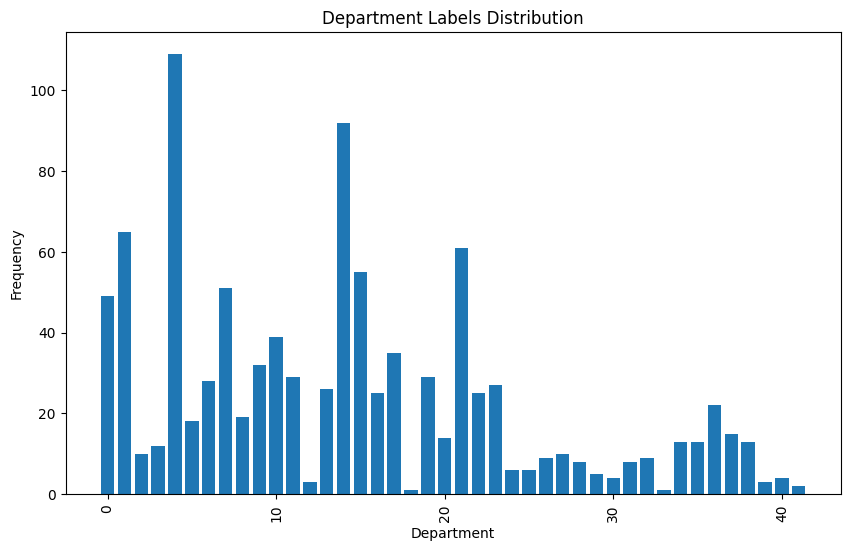

In [25]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import adjusted_mutual_info_score

# Load the preprocessed Email graph
email_graph = nx.read_gml('data/email_graph.gml')

# Load the department labels from the correct file
labels_df = pd.read_csv('data/email-Eu-core-department-labels.txt', sep=' ', header=None, names=['node', 'department'])

# Perform community detection using the Louvain method
partition_email = community_louvain.best_partition(email_graph)

# Convert partitions and labels into lists for AMI calculation
detected_communities = []
true_labels = []

for node in email_graph.nodes():
    if node in labels_df['node'].values:
        detected_communities.append(partition_email[node])
        true_labels.append(labels_df.loc[labels_df['node'] == node, 'department'].values[0])
    else:
        print(f"Node {node} not found in labels_df")

# Calculate AMI
if detected_communities and true_labels:  # Check if lists are not empty
    ami_score = adjusted_mutual_info_score(true_labels, detected_communities)
    print(f"Adjusted Mutual Information (AMI) score: {ami_score}")
else:
    print("No matching nodes found between detected communities and true labels.")

# Create a bar plot for department labels distribution
label_counts = labels_df['department'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Department')
plt.ylabel('Frequency')
plt.title('Department Labels Distribution')
plt.xticks(rotation=90)
plt.show()


In [26]:
import networkx as nx
import community as community_louvain
import pandas as pd
from sklearn.metrics import adjusted_mutual_info_score

# Load the preprocessed email graph
email_graph = nx.read_gml('data/email_graph.gml')

# Load the ground truth labels (assuming you have a DataFrame with 'node' and 'department' columns)
labels_df = pd.read_csv('data/email-Eu-core-department-labels.txt', delim_whitespace=True, names=['node', 'department'])

# Perform community detection on the email graph using the Louvain method
partition_email = community_louvain.best_partition(email_graph)

# Prepare the ground truth and predicted labels for AMI calculation
ground_truth_labels = []
predicted_labels = []

# Ensure matching nodes between detected communities and true labels
common_nodes = set(email_graph.nodes()).intersection(set(labels_df['node']))

for node in common_nodes:
    ground_truth_labels.append(labels_df[labels_df['node'] == node]['department'].values[0])
    predicted_labels.append(partition_email[node])

# Calculate Adjusted Mutual Information (AMI)
ami_score = adjusted_mutual_info_score(ground_truth_labels, predicted_labels)
print(f"Adjusted Mutual Information (AMI) Score: {ami_score}")


Adjusted Mutual Information (AMI) Score: 1.0


/var/folders/ng/mym24qcx4s1g78pc10x2w6sh0000gn/T/ipykernel_78631/1077319882.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  labels_df = pd.read_csv('data/email-Eu-core-department-labels.txt', delim_whitespace=True, names=['node', 'department'])


Number of communities detected: 8
Email dataset modularity: 0.4130240740226345


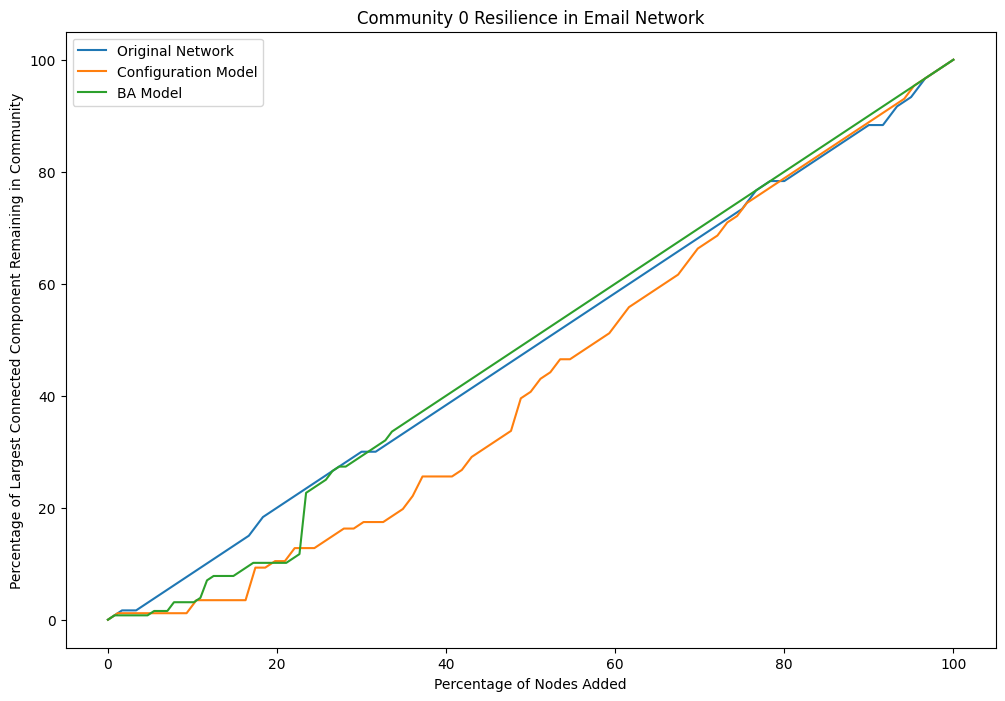

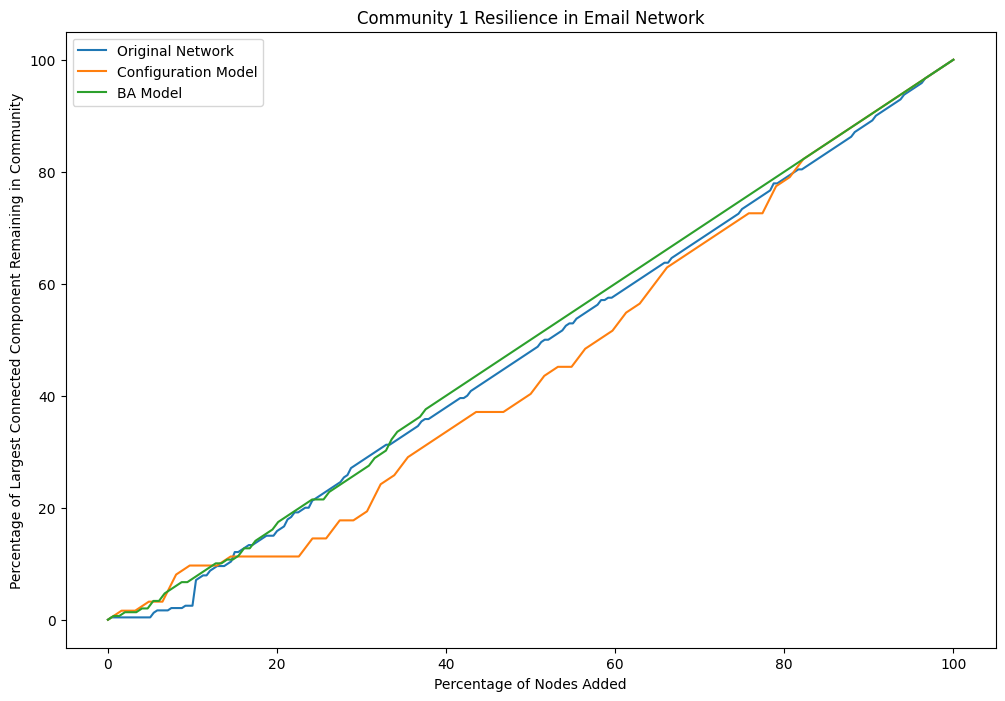

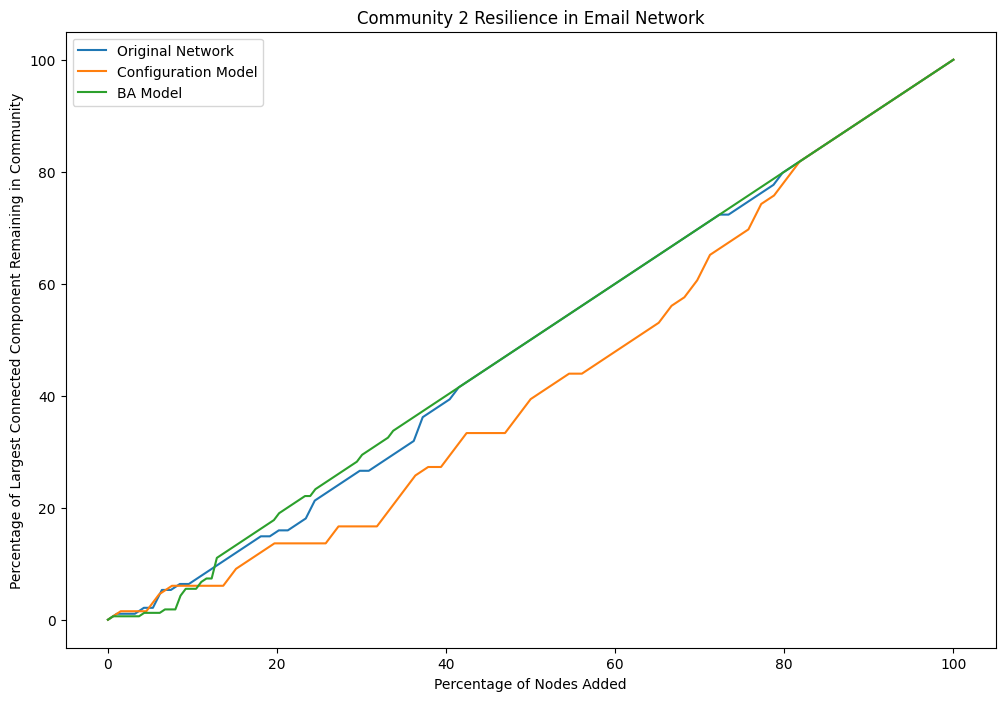

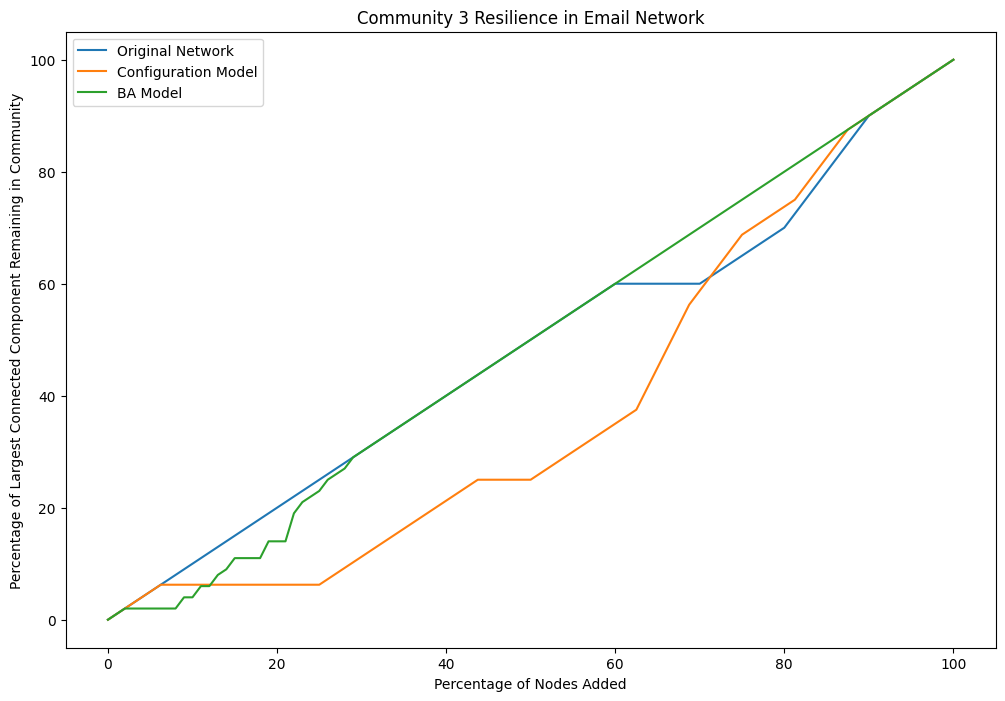

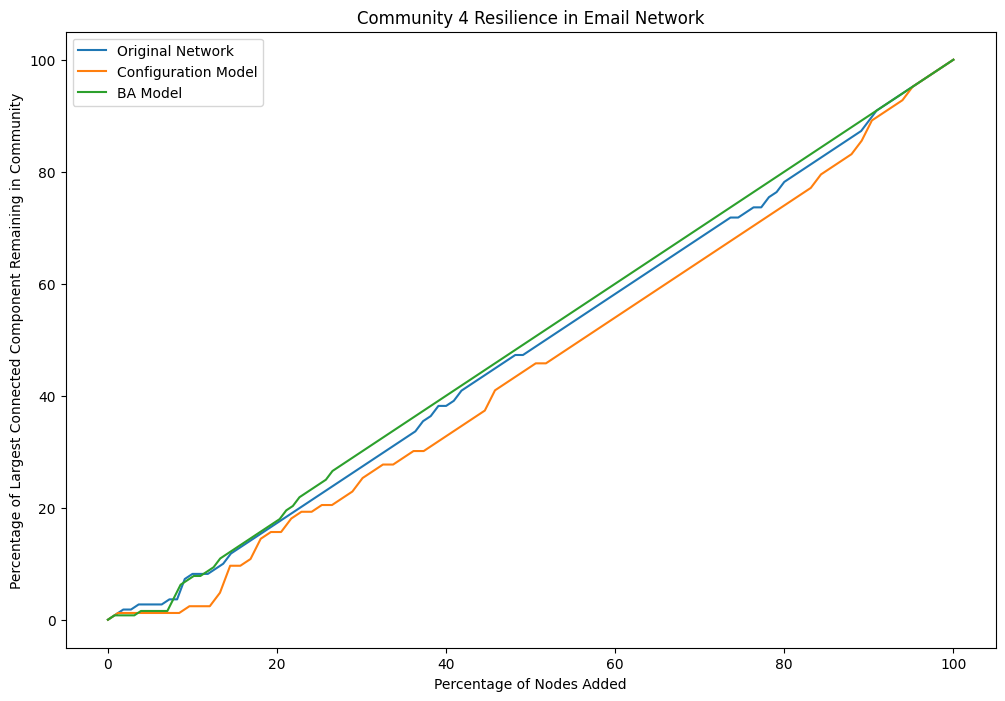

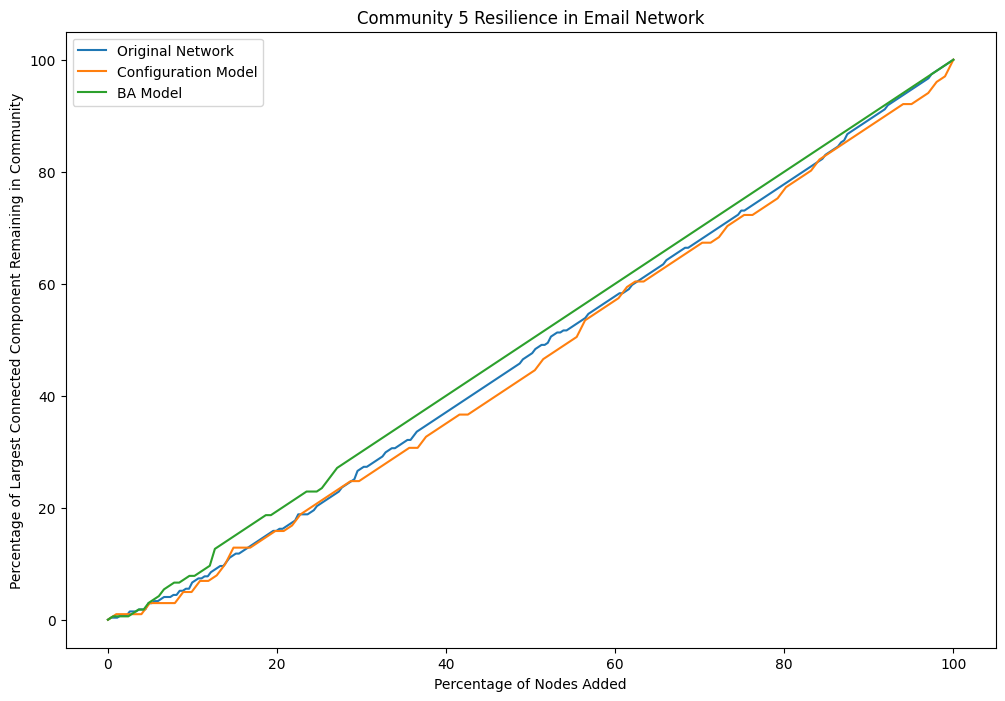

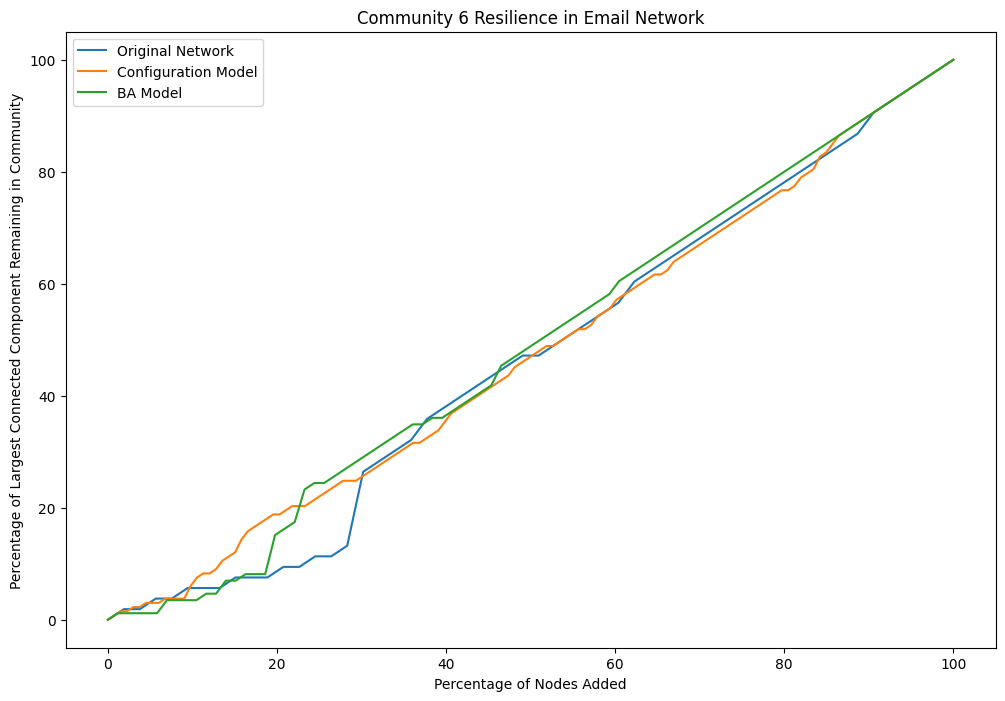

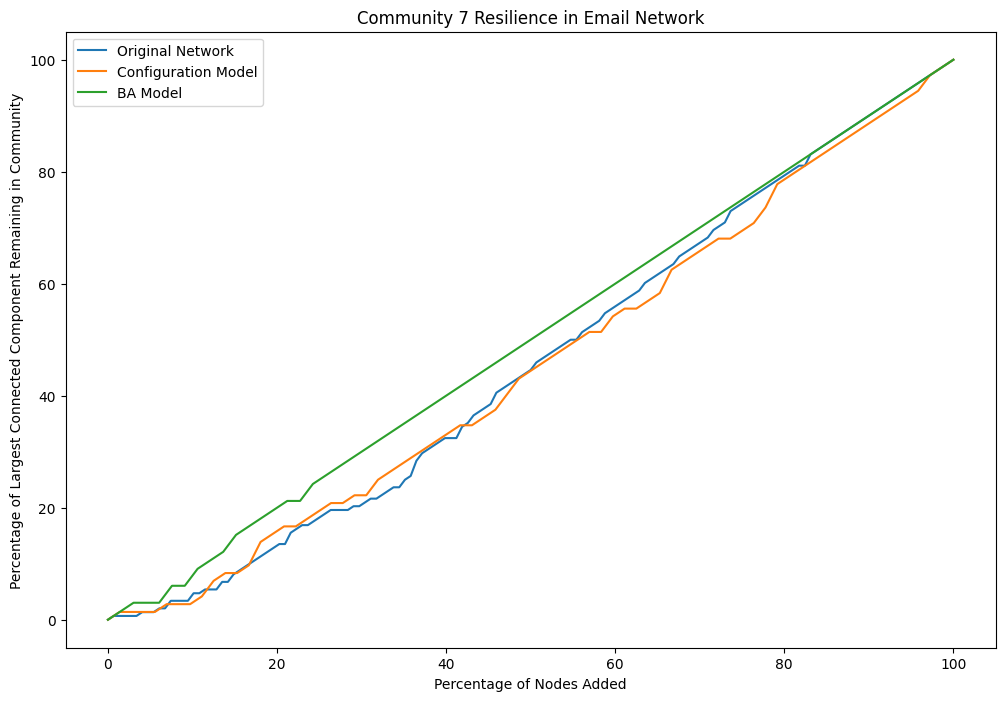

In [32]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import numpy as np

# Define random order function
def random_order(graph):
    nodes = list(graph.nodes())
    np.random.shuffle(nodes)
    return nodes

# Define resilience computation function based on percentage of nodes added
def compute_resilience_percentage(graph, attack_order):
    total_nodes = len(attack_order)
    resilience = [0]  # Initialize with 0 to ensure the plot starts from 0
    added_graph = nx.Graph()

    for i, node in enumerate(attack_order):
        added_graph.add_node(node)
        for neighbor in graph.neighbors(node):
            if added_graph.has_node(neighbor):
                added_graph.add_edge(node, neighbor)
        remaining_components = list(nx.connected_components(added_graph))
        if remaining_components:
            largest_component_size = len(max(remaining_components, key=len))
            resilience.append(largest_component_size / total_nodes * 100)
        else:
            resilience.append(0)
    return resilience

# Define community resilience computation function
def compute_community_resilience_percentage(graph, partition):
    community_resilience = {}
    for comm_id in set(partition.values()):
        subgraph_nodes = [node for node in partition if partition[node] == comm_id]
        subgraph = graph.subgraph(subgraph_nodes).copy()
        attack_order = random_order(subgraph)
        resilience = compute_resilience_percentage(subgraph, attack_order)
        community_resilience[comm_id] = resilience
    return community_resilience

# Load the preprocessed Email graph
email_graph = nx.read_gml('data/email_graph.gml')

# Detect communities using the Louvain method
partition_email = community_louvain.best_partition(email_graph)
print(f"Number of communities detected: {len(set(partition_email.values()))}")

# Calculate modularity
modularity_email = community_louvain.modularity(partition_email, email_graph)
print(f"Email dataset modularity: {modularity_email}")

# Generate synthetic models
degree_sequence = [d for n, d in email_graph.degree()]
configuration_model_email = nx.configuration_model(degree_sequence)
ba_model_email = nx.barabasi_albert_graph(email_graph.number_of_nodes(), int(sum(degree_sequence) / email_graph.number_of_nodes()))

# Convert configuration model to a simple graph
configuration_model_email = nx.Graph(configuration_model_email)

# Detect communities in synthetic models
partition_configuration_model_email = community_louvain.best_partition(configuration_model_email)
partition_ba_email = community_louvain.best_partition(ba_model_email)

# Calculate community resilience for each model
community_resilience_email = compute_community_resilience_percentage(email_graph, partition_email)
community_resilience_configuration_email = compute_community_resilience_percentage(configuration_model_email, partition_configuration_model_email)
community_resilience_ba_email = compute_community_resilience_percentage(ba_model_email, partition_ba_email)

# Plot community resilience for all communities across models
for comm_id in sorted(community_resilience_email.keys()):
    plt.figure(figsize=(12, 8))
    
    # Get the appropriate x_values length
    x_values_email = np.linspace(0, 100, len(community_resilience_email[comm_id]))  
    plt.plot(x_values_email, community_resilience_email[comm_id], label='Original Network')
    
    if comm_id in community_resilience_configuration_email:
        x_values_conf = np.linspace(0, 100, len(community_resilience_configuration_email[comm_id]))
        plt.plot(x_values_conf, community_resilience_configuration_email[comm_id], label='Configuration Model')
    
    if comm_id in community_resilience_ba_email:
        x_values_ba = np.linspace(0, 100, len(community_resilience_ba_email[comm_id]))
        plt.plot(x_values_ba, community_resilience_ba_email[comm_id], label='BA Model')
    
    plt.xlabel('Percentage of Nodes Added')
    plt.ylabel('Percentage of Largest Connected Component Remaining in Community')
    plt.title(f'Community {comm_id} Resilience in Email Network')
    plt.legend()
    plt.show()


Number of communities detected: 7
Email dataset modularity: 0.4144303443286118


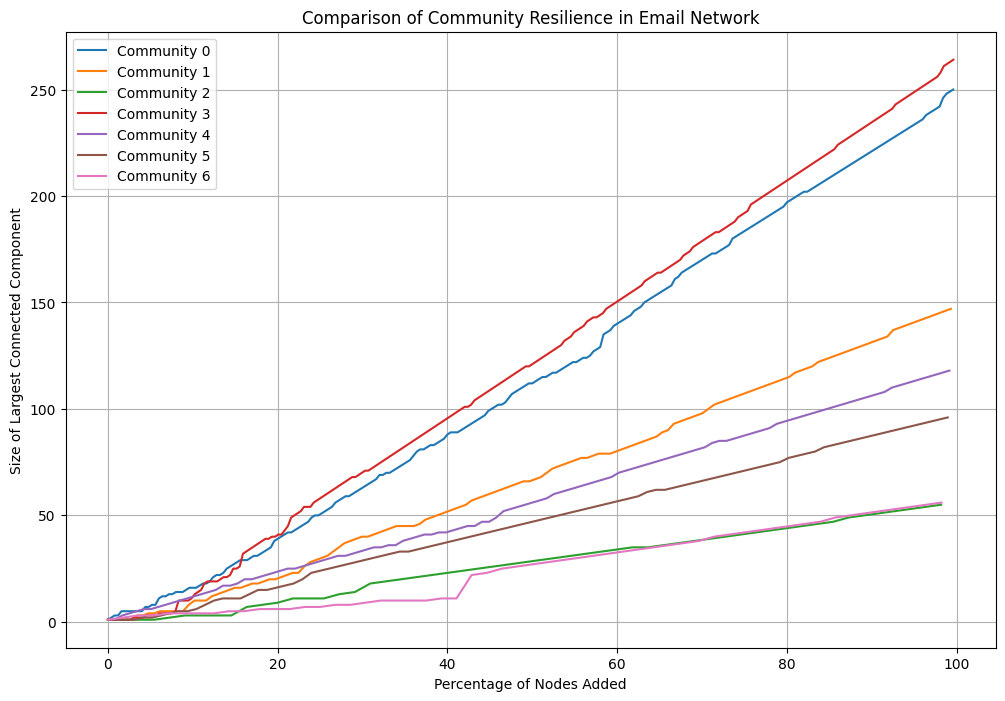

In [33]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import random

# Define random order function
def random_order(graph):
    nodes = list(graph.nodes())
    random.shuffle(nodes)
    return nodes

# Define resilience computation function
def compute_resilience_adding_nodes(graph, attack_order):
    initial_nodes = graph.number_of_nodes()
    resilience = []
    added_graph = nx.Graph()
    
    for node in attack_order:
        added_graph.add_node(node)
        for neighbor in graph.neighbors(node):
            if added_graph.has_node(neighbor):
                added_graph.add_edge(node, neighbor)
        remaining_components = list(nx.connected_components(added_graph))
        if remaining_components:
            resilience.append(len(max(remaining_components, key=len)))
        else:
            resilience.append(0)
    return resilience

# Define community resilience computation function
def compute_community_resilience(graph, partition):
    community_resilience = {}
    for comm_id in set(partition.values()):
        subgraph_nodes = [node for node in partition if partition[node] == comm_id]
        subgraph = graph.subgraph(subgraph_nodes).copy()
        attack_order = random_order(subgraph)
        resilience = compute_resilience_adding_nodes(subgraph, attack_order)
        community_resilience[comm_id] = resilience
    return community_resilience

# Load the preprocessed Email graph
email_graph = nx.read_gml('data/email_graph.gml')

# Detect communities using the Louvain method
partition_email = community_louvain.best_partition(email_graph)
print(f"Number of communities detected: {len(set(partition_email.values()))}")

# Calculate modularity
modularity_email = community_louvain.modularity(partition_email, email_graph)
print(f"Email dataset modularity: {modularity_email}")

# Compute community resilience for the original network
community_resilience_email = compute_community_resilience(email_graph, partition_email)

# Plot all community resilience curves on the same figure
plt.figure(figsize=(12, 8))

for comm_id, resilience in community_resilience_email.items():
    # Normalize x-axis as percentage of nodes added
    x_axis_normalized = [(i / len(resilience)) * 100 for i in range(len(resilience))]
    plt.plot(x_axis_normalized, resilience, label=f'Community {comm_id}')

plt.xlabel('Percentage of Nodes Added')
plt.ylabel('Size of Largest Connected Component')
plt.title('Comparison of Community Resilience in Email Network')
plt.legend()
plt.grid(True)
plt.show()


Detected communities and their sizes: Counter({3: 264, 0: 250, 1: 147, 4: 118, 5: 96, 6: 56, 2: 55})


In [35]:
partition_email = community_louvain.best_partition(email_graph, resolution=1.5)


In [36]:
from collections import Counter

community_sizes = Counter(partition_email.values())
print(f"Detected communities and their sizes: {community_sizes}")


Detected communities and their sizes: Counter({12: 146, 1: 112, 4: 107, 0: 93, 2: 92, 5: 90, 8: 74, 9: 73, 6: 48, 7: 44, 10: 39, 3: 35, 11: 33})


Number of communities detected: 8
Email dataset modularity: 0.41279632931173715


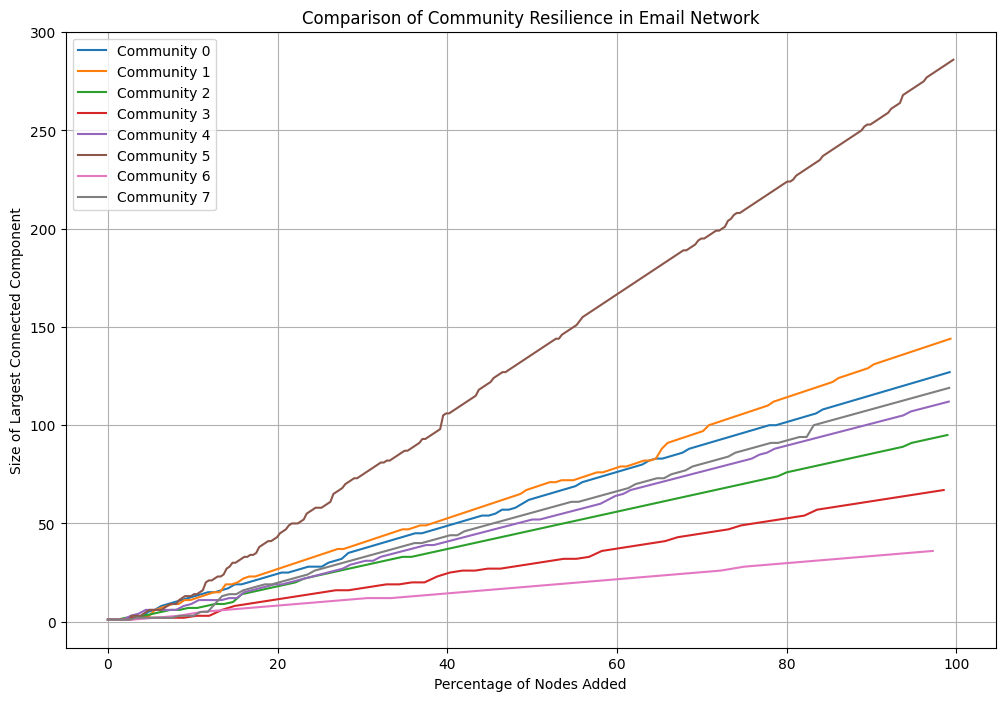

In [37]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import random

# Define random order function
def random_order(graph):
    nodes = list(graph.nodes())
    random.shuffle(nodes)
    return nodes

# Define resilience computation function
def compute_resilience_adding_nodes(graph, attack_order):
    initial_nodes = graph.number_of_nodes()
    resilience = []
    added_graph = nx.Graph()
    
    for node in attack_order:
        added_graph.add_node(node)
        for neighbor in graph.neighbors(node):
            if added_graph.has_node(neighbor):
                added_graph.add_edge(node, neighbor)
        remaining_components = list(nx.connected_components(added_graph))
        if remaining_components:
            resilience.append(len(max(remaining_components, key=len)))
        else:
            resilience.append(0)
    return resilience

# Define community resilience computation function
def compute_community_resilience(graph, partition):
    community_resilience = {}
    for comm_id in set(partition.values()):
        subgraph_nodes = [node for node in partition if partition[node] == comm_id]
        subgraph = graph.subgraph(subgraph_nodes).copy()
        attack_order = random_order(subgraph)
        resilience = compute_resilience_adding_nodes(subgraph, attack_order)
        community_resilience[comm_id] = resilience
    return community_resilience

# Load the preprocessed Email graph
email_graph = nx.read_gml('data/email_graph.gml')

# Detect communities using the Louvain method
partition_email = community_louvain.best_partition(email_graph)
print(f"Number of communities detected: {len(set(partition_email.values()))}")

# Calculate modularity
modularity_email = community_louvain.modularity(partition_email, email_graph)
print(f"Email dataset modularity: {modularity_email}")

# Compute community resilience for the original network
community_resilience_email = compute_community_resilience(email_graph, partition_email)

# Plot all community resilience curves on the same figure
plt.figure(figsize=(12, 8))

for comm_id, resilience in community_resilience_email.items():
    # Normalize x-axis as percentage of nodes added
    x_axis_normalized = [(i / len(resilience)) * 100 for i in range(len(resilience))]
    plt.plot(x_axis_normalized, resilience, label=f'Community {comm_id}')

plt.xlabel('Percentage of Nodes Added')
plt.ylabel('Size of Largest Connected Component')
plt.title('Comparison of Community Resilience in Email Network')
plt.legend()
plt.grid(True)
plt.show()
